## Problem Statement 

To build a model that is able to classify customer complaints based on the products/services. By doing so, we can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

We will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, we need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, we will be able to map each ticket onto its respective department/category. We can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, we can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

We need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud
from nltk.util import ngrams
import itertools

from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import CategoricalNB, GaussianNB, BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

pd.set_option('display.max_colwidth', None)

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
#This is only required when executing this notebook in google drive
'''
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive',force_remount=True)\n"

In [3]:
with open('complaints.json') as f:  
      data = json.load(f)
df=pd.DataFrame(data)
print(df.shape)

(78313, 5)


## Data preparation

In [4]:
# Inspect the dataframe to understand the given data.
complaint_what_happened = [value.get('complaint_what_happened') for key,value in df['_source'].to_dict().items()]

In [5]:
# Inspect the dataframe to understand the given data.
complaint_what_happened = pd.Series(complaint_what_happened)
print(complaint_what_happened[:3])
df['complaint_what_happened'] = complaint_what_happened

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
1    Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.
2       

In [6]:
#Understand basic details about the dataframe
print(df.shape)
print()
print(df.columns)
print()
print(df.index)

(78313, 6)

Index(['_index', '_type', '_id', '_score', '_source',
       'complaint_what_happened'],
      dtype='object')

RangeIndex(start=0, stop=78313, step=1)


In [7]:
#View top 3 rows of the dataframe
df.head(3)

,_index,_type,_id,_score,_source,complaint_what_happened
0,complaint-public-v2,complaint,3211475,0.0,"{'tags': None, 'zip_code': '90301', 'complaint_id': '3211475', 'issue': 'Attempts to collect debt not owed', 'date_received': '2019-04-13T12:00:00-05:00', 'state': 'CA', 'consumer_disputed': 'N/A', 'product': 'Debt collection', 'company_response': 'Closed with explanation', 'company': 'JPMORGAN CHASE & CO.', 'submitted_via': 'Web', 'date_sent_to_company': '2019-04-13T12:00:00-05:00', 'company_public_response': None, 'sub_product': 'Credit card debt', 'timely': 'Yes', 'complaint_what_happened': '', 'sub_issue': 'Debt is not yours', 'consumer_consent_provided': 'Consent not provided'}",
1,complaint-public-v2,complaint,3229299,0.0,"{'tags': 'Servicemember', 'zip_code': '319XX', 'complaint_id': '3229299', 'issue': 'Written notification about debt', 'date_received': '2019-05-01T12:00:00-05:00', 'state': 'GA', 'consumer_disputed': 'N/A', 'product': 'Debt collection', 'company_response': 'Closed with explanation', 'company': 'JPMORGAN CHASE & CO.', 'submitted_via': 'Web', 'date_sent_to_company': '2019-05-01T12:00:00-05:00', 'company_public_response': None, 'sub_product': 'Credit card debt', 'timely': 'Yes', 'complaint_what_happened': 'Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. In 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. I have a right to know this information as a consumer. Chase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.', 'sub_issue': 'Didn't receive enough information to verify debt', 'consumer_consent_provided': 'Consent provided'}",Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.
2,complaint-public-v2,complaint,3199379,0.0,"{'tags': None, 'zip_code': '77069', 'complaint_id': '3199379', 'issue': 'Other features, terms, or problems', 'date_received': '2019-04-02T12:00:00-05:00', 'state': 'TX', 'consumer_disputed': 'N/A', 'product': 'Credit card or prepaid card', 'company_response': 'Closed with explanation', 'company': 'JPMORGAN CHASE & CO.', 'submitted_via': 'Web', 'date_sent_to_company': '2019-04-02T12:00:00-05:00', 'company_public_response': None, 'sub_product': 'General-purpose credit card or charge card', 'timely': 'Yes', 'complaint_what_happened': 'I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.', 'sub_issue': 'Problem with rewards from credit card', 'consumer_consent_provided': 'Consent provided'}",I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.


In [8]:
#Understanding/inspecting below columns and below columns are not adding any meaningful info being static.
print(df['_type'].value_counts())
print()
print(df['_index'].value_counts())
print()
print(df['_score'].value_counts())
print()
print(df['_id'].value_counts())
print()

complaint    78313
Name: _type, dtype: int64

complaint-public-v2    78313
Name: _index, dtype: int64

0.0    78313
Name: _score, dtype: int64

3499560    1
3112992    1
36559      1
326536     1
2594787    1
          ..
3148006    1
1619473    1
2666974    1
113410     1
2959934    1
Name: _id, Length: 78313, dtype: int64



In [9]:
#print the column names
#Assign new column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source',
       'complaint_what_happened'],
      dtype='object')


In [10]:
#Assign nan in place of blanks in the complaints column OR ensure dataframe only contains rows where complaint is present
df[df['complaint_what_happened'] == ''].shape

(57241, 6)

In [11]:
#Remove all rows where complaints column is nan
df = df[~(df['complaint_what_happened'] == '')]

In [12]:
df.shape

(21072, 6)

In [13]:
print("Total rows in dataframe where complaint is absent/missing = 57241" )
print("Total rows in dataframe where complaint is present= ",df.shape[0] )
print("Total records are ",57241+21072)


Total rows in dataframe where complaint is absent/missing = 57241
Total rows in dataframe where complaint is present=  21072
Total records are  78313


In [14]:
#Inspecting updated dataframe, however we see the index is not correctly aligned because we have not included rows where complaint is blanking. Hence, we need to reset index
df.head(3)

,_index,_type,_id,_score,_source,complaint_what_happened
1,complaint-public-v2,complaint,3229299,0.0,"{'tags': 'Servicemember', 'zip_code': '319XX', 'complaint_id': '3229299', 'issue': 'Written notification about debt', 'date_received': '2019-05-01T12:00:00-05:00', 'state': 'GA', 'consumer_disputed': 'N/A', 'product': 'Debt collection', 'company_response': 'Closed with explanation', 'company': 'JPMORGAN CHASE & CO.', 'submitted_via': 'Web', 'date_sent_to_company': '2019-05-01T12:00:00-05:00', 'company_public_response': None, 'sub_product': 'Credit card debt', 'timely': 'Yes', 'complaint_what_happened': 'Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. In 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. I have a right to know this information as a consumer. Chase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.', 'sub_issue': 'Didn't receive enough information to verify debt', 'consumer_consent_provided': 'Consent provided'}",Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.
2,complaint-public-v2,complaint,3199379,0.0,"{'tags': None, 'zip_code': '77069', 'complaint_id': '3199379', 'issue': 'Other features, terms, or problems', 'date_received': '2019-04-02T12:00:00-05:00', 'state': 'TX', 'consumer_disputed': 'N/A', 'product': 'Credit card or prepaid card', 'company_response': 'Closed with explanation', 'company': 'JPMORGAN CHASE & CO.', 'submitted_via': 'Web', 'date_sent_to_company': '2019-04-02T12:00:00-05:00', 'company_public_response': None, 'sub_product': 'General-purpose credit card or charge card', 'timely': 'Yes', 'complaint_what_happened': 'I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.', 'sub_issue': 'Problem with rewards from credit card', 'consumer_consent_provided': 'Consent provided'}",I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.
10,complaint-public-v2,complaint,3233499,0.0,"{'tags': None, 'zip_code': '104XX', 'complaint_id': '3233499', 'issue': 'Incorrect information on your report', 'date_received': '2019-05-06T12:00:00-05:00', 'state': 'NY', 'consumer_disputed': 'N/A', 'product': 'Credit reporting, credit repair services, or other personal consumer reports', 'company_response': 'Closed with explanation', 'company': 'JPMORGAN CHASE & CO.', 'submitted_via': 'Web', 'date_sent_to_company': '2019-05-06T12:00:00-05:00', 'company_public_response': None, 'sub_product': 'Other personal consumer report', 'timely': 'Yes', 'complaint_what_happened': 'Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.', 'sub_issue': 'Information belongs to someone else

In [15]:
#Reset the index for dataframe df
df.reset_index(drop=True,inplace=True)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [16]:
# Write your function here to clean the text and remove all the unnecessary elements.
# Write your function to Lemmatize the texts

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

#This function takes a document(complaint) as input, preprocesses it and returns preprocessed output 
def preprocess(document):
    'changes document to lower case and removes stopwords'

    # Make the text lowercase
    document = document.lower()
    
    #Remove text in square brackets
    document=re.sub("\{\w*\}", "", document)
    document=re.sub("\[\w*\]", "", document)
    document=re.sub("\(\w*\)", "", document)
    
    #Remove punctuation and words containing numbers
    document = re.sub("[^\sA-z]","",document)
    
    # tokenize into words
    words = word_tokenize(document)
    
    # remove stop words
    #words = [word for word in words if word not in stopwords.words("english")]
    
    # Lemmatizing the words
    words = [wordnet_lemmatizer.lemmatize(word) for word in words]
    
    # join words to make sentence
    document = " ".join(words)
    
    return document

[nltk_data] Downloading package punkt to /Users/Kirwe-
[nltk_data]     Macbook/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/Kirwe-
[nltk_data]     Macbook/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Kirwe-
[nltk_data]     Macbook/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/Kirwe-
[nltk_data]     Macbook/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [17]:
#Preprocess each complaint in the dataframe and store it in new column named 'preprocessed_complaint'
preprocessed_complaint = [preprocess(complaint) for complaint in tqdm(df['complaint_what_happened'])]
preprocessed_complaint = pd.Series(preprocessed_complaint)
df['preprocessed_complaint'] = preprocessed_complaint

100%|██████████| 21072/21072 [00:44<00:00, 471.54it/s]


In [18]:
#View the latest version of dataframe 'df'
df.head(3)

,_index,_type,_id,_score,_source,complaint_what_happened,preprocessed_complaint
0,complaint-public-v2,complaint,3229299,0.0,"{'tags': 'Servicemember', 'zip_code': '319XX', 'complaint_id': '3229299', 'issue': 'Written notification about debt', 'date_received': '2019-05-01T12:00:00-05:00', 'state': 'GA', 'consumer_disputed': 'N/A', 'product': 'Debt collection', 'company_response': 'Closed with explanation', 'company': 'JPMORGAN CHASE & CO.', 'submitted_via': 'Web', 'date_sent_to_company': '2019-05-01T12:00:00-05:00', 'company_public_response': None, 'sub_product': 'Credit card debt', 'timely': 'Yes', 'complaint_what_happened': 'Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. In 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. I have a right to know this information as a consumer. Chase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.', 'sub_issue': 'Didn't receive enough information to verify debt', 'consumer_consent_provided': 'Consent provided'}",Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help
1,complaint-public-v2,complaint,3199379,0.0,"{'tags': None, 'zip_code': '77069', 'complaint_id': '3199379', 'issue': 'Other features, terms, or problems', 'date_received': '2019-04-02T12:00:00-05:00', 'state': 'TX', 'consumer_disputed': 'N/A', 'product': 'Credit card or prepaid card', 'company_response': 'Closed with explanation', 'company': 'JPMORGAN CHASE & CO.', 'submitted_via': 'Web', 'date_sent_to_company': '2019-04-02T12:00:00-05:00', 'company_public_response': None, 'sub_product': 'General-purpose credit card or charge card', 'timely': 'Yes', 'complaint_what_happened': 'I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.', 'sub_issue': 'Problem with rewards from credit card', 'consumer_consent_provided': 'Consent provided'}",I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my xxxx xxxx card in xxxx and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx ha the recording of the agent who wa misled me
2,complaint-public-v2,complaint,3233499,0.0,"{'tags': None, 'zip_code': '

In [19]:
#df.drop(columns=['_id','_index','_type','_score','_source'],inplace=True)

#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 

print("df Dataframe = Before dropping columns \n",df.columns)

df_clean = df.drop(columns=['_id','_index','_type','_score','_source'])

print("df_clean Dataframe = After dropping redundant columns \n",df_clean.columns)

df Dataframe = Before dropping columns 
 Index(['_index', '_type', '_id', '_score', '_source',
       'complaint_what_happened', 'preprocessed_complaint'],
      dtype='object')
df_clean Dataframe = After dropping redundant columns 
 Index(['complaint_what_happened', 'preprocessed_complaint'], dtype='object')


In [20]:
#View the new  dataframe 'df_clean'
df_clean.head(3)

,complaint_what_happened,preprocessed_complaint
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my xxxx xxxx card in xxxx and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx ha the recording of the agent who wa misled me
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card wa reported on xxxx however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant


In [21]:
#Write your function to extract the POS tags 

def pos_tag(text):
  # write your code here
    model = spacy.load("en_core_web_sm")
    complaint_POS_removed = []
    
    for i in tqdm(range(0,len(text))):
        sent = model(text[i])
        sent_holder=[]
        
        for token in sent:
            if(token.pos_ in ["NOUN"]):
                sent_holder.append(token)
        
        #print(sent_holder)
        res = " ".join([str(ele) for ele in sent_holder])
        #print(res)
        complaint_POS_removed.append(res)
        
    return pd.Series(complaint_POS_removed)

In [22]:
#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] =  pos_tag(df_clean['preprocessed_complaint'])
#df_clean["complaint_POS_removed"] =  pos_tag(df['preprocessed_complaint'])

100%|██████████| 21072/21072 [14:42<00:00, 23.88it/s] 


In [23]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head(3)

,complaint_what_happened,preprocessed_complaint,complaint_POS_removed
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop debt verification statement bank debt mail month debt right information consumer chase thanks advance help
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my xxxx xxxx card in xxxx and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx ha the recording of the agent who wa misled me,agent upgrade anniversary date agent information order account anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card wa reported on xxxx however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,application identity consent service credit identity applicant


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [24]:
#Visualise the data according to the 'Complaint' character length

complaintLength = [len(complaint.split()) for complaint in tqdm(df['complaint_what_happened'])]
complaintLength = pd.Series(complaintLength)

#View length of first 5 complaints from the dataframe
complaintLength[:5]

100%|██████████| 21072/21072 [00:00<00:00, 44731.52it/s]


0     92
1     63
2     32
3    269
4     95
dtype: int64

In [25]:
# finding out the word length of the top 5 most lengthy complaints
complaintLength.sort_values(ascending=False, inplace=True)
complaintLength[:5]

11241    5573
14251    5103
436      4994
2308     4902
1130     4440
dtype: int64

/Users/Kirwe-Macbook/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



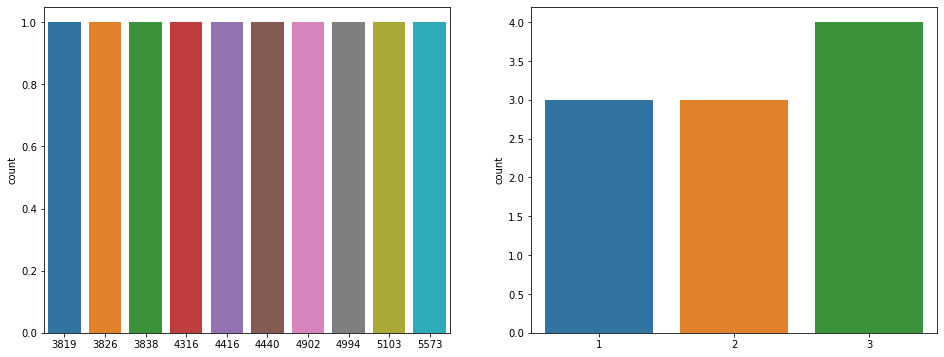

In [26]:
#The left plot shows the count of complaints having the highest number of words in complaint
#The right plot shows the count of complaints having the least number of words in complaint 

fig, ax = plt.subplots(1,2,figsize=(16,6))
sns.countplot(x=complaintLength[:10],ax=ax[0])
sns.countplot(x=complaintLength[-10:],ax=ax[1])
fig.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

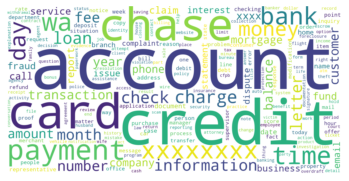

In [27]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text //Always on preprocessed

word_cloud = WordCloud(collocations = False, background_color = 'white',width = 1600, height = 800).generate(' '.join(df_clean['complaint_POS_removed']))
plt.imshow(word_cloud, interpolation='bilinear')

plt.axis("off")
plt.show()

In [28]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the 

1.   List item
2.   List item

complaints after processing the text.

In [29]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
unigrams = ngrams(' '.join(df_clean['complaint_POS_removed']).split(), 1)
nltk.FreqDist(unigrams).most_common(15)

[(('account',), 45467),
 (('credit',), 31376),
 (('card',), 29055),
 (('chase',), 25695),
 (('payment',), 20809),
 (('wa',), 16611),
 (('time',), 15927),
 (('xxxxxxxx',), 15071),
 (('bank',), 14936),
 (('day',), 12760),
 (('money',), 11927),
 (('charge',), 11880),
 (('loan',), 10396),
 (('check',), 9932),
 (('information',), 9608)]

In [30]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bigrams = ngrams(' '.join(df_clean['complaint_POS_removed']).split(), 2)
nltk.FreqDist(bigrams).most_common(15)

[(('credit', 'card'), 12146),
 (('credit', 'report'), 3686),
 (('checking', 'account'), 2950),
 (('customer', 'service'), 2718),
 (('account', 'account'), 2627),
 (('bank', 'account'), 2010),
 (('chase', 'account'), 1906),
 (('chase', 'credit'), 1838),
 (('debit', 'card'), 1806),
 (('credit', 'score'), 1707),
 (('phone', 'call'), 1623),
 (('card', 'account'), 1608),
 (('account', 'credit'), 1604),
 (('account', 'chase'), 1570),
 (('payment', 'payment'), 1398)]

In [31]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
trigrams = ngrams(' '.join(df_clean['complaint_POS_removed']).split(), 3)
nltk.FreqDist(trigrams).most_common(15)

[(('chase', 'credit', 'card'), 1330),
 (('credit', 'card', 'company'), 934),
 (('credit', 'card', 'account'), 934),
 (('credit', 'card', 'credit'), 583),
 (('inquiry', 'credit', 'report'), 533),
 (('card', 'credit', 'card'), 520),
 (('account', 'credit', 'card'), 508),
 (('charge', 'credit', 'card'), 394),
 (('credit', 'report', 'credit'), 380),
 (('credit', 'reporting', 'agency'), 367),
 (('credit', 'card', 'payment'), 330),
 (('credit', 'card', 'card'), 324),
 (('credit', 'card', 'chase'), 322),
 (('account', 'credit', 'report'), 319),
 (('credit', 'reporting', 'act'), 316)]

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [32]:
df_clean.head(3)

,complaint_what_happened,preprocessed_complaint,complaint_POS_removed,Complaint_clean
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop debt verification statement bank debt mail month debt right information consumer chase thanks advance help,morning name stop debt verification statement bank debt mail month debt right information consumer chase thanks advance help
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my xxxx xxxx card in xxxx and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx ha the recording of the agent who wa misled me,agent upgrade anniversary date agent information order account anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent,agent upgrade anniversary date agent information order account anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card wa reported on xxxx however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,application identity consent service credit identity applicant,application identity consent service credit identity applicant


In [33]:
#Not following this approach and instead doing it via regular expressions
#df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

def removeMasing(document):
    document = re.sub("x{2,}","",document)
    return document

Complaint_clean_no_masking = [removeMasing(complaint) for complaint in tqdm(df_clean['Complaint_clean'])]
df_clean['Complaint_clean_no_masking'] = pd.Series(Complaint_clean_no_masking)

100%|██████████| 21072/21072 [00:00<00:00, 92437.71it/s]


In [34]:
#All masked texts has been removed
df_clean.head(3)

,complaint_what_happened,preprocessed_complaint,complaint_POS_removed,Complaint_clean,Complaint_clean_no_masking
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop debt verification statement bank debt mail month debt right information consumer chase thanks advance help,morning name stop debt verification statement bank debt mail month debt right information consumer chase thanks advance help,morning name stop debt verification statement bank debt mail month debt right information consumer chase thanks advance help
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my xxxx xxxx card in xxxx and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx ha the recording of the agent who wa misled me,agent upgrade anniversary date agent information order account anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent,agent upgrade anniversary date agent information order account anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent,agent upgrade anniversary date agent information order account anniversary date consent recording agent
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card wa reported on xxxx however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,application identity consent service credit identity applicant,application identity consent service credit identity applicant,application identity consent service credit identity applicant


## Feature Extraction

The TF-IDF representation, also called the TF-IDF model, takes into the account the importance of each word. In the bag-of-words model, each word is assumed to be equally important, which is of course not correct.

**Higher weights are assigned to terms that are present frequently in a document and which are rare among all documents. On the other hand, a low score is assigned to terms which are common across all documents.**


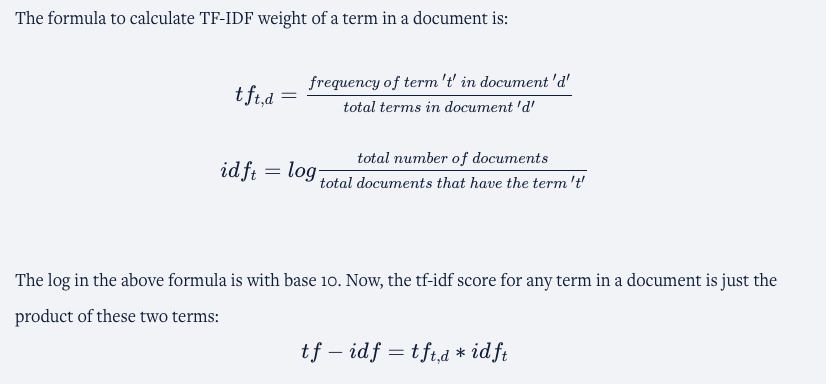


Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [35]:
#Write your code here to initialise the TfidfVectorizer 
vectorizer = TfidfVectorizer(max_df=0.95,min_df=2)
X = vectorizer.fit_transform(df_clean['Complaint_clean_no_masking'])

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [36]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())

,aaaratings,aba,abandonment,abatement,abbreviation,abide,ability,about,absence,absent,...,yield,yoga,yours,yourselves,youth,yr,ytd,zip,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task, we have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [37]:
len(vectorizer.get_feature_names())

6062

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

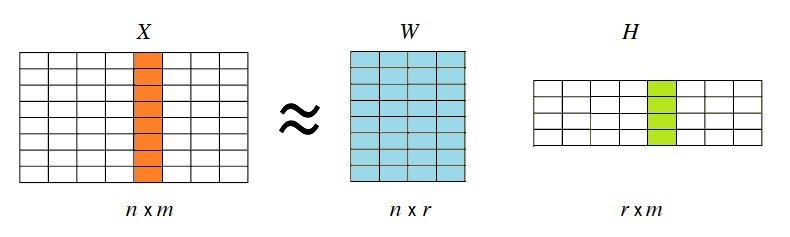

In [38]:
#Load your nmf_model with the n_components i.e 5
import warnings
warnings.filterwarnings("ignore")

num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics,random_state=40)
W = nmf_model.fit_transform(X)  # Document-topic matrix
H = nmf_model.components_       # Topic-term matrix

print("W(Document-topic matrix) shape = ", W.shape)
print("H(Topic-term matrix) shape = ", H.shape)

W(Document-topic matrix) shape =  (21072, 5)
H(Topic-term matrix) shape =  (5, 6062)


In [39]:
#Print the Top15 words for each of the topics

words = np.array(vectorizer.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,money,bank,fund,checking,chase,deposit,branch,day,fee,wa,business,number,transaction
Topic 2,card,credit,balance,chase,account,fee,interest,limit,score,year,purchase,month,point,offer,reason
Topic 3,payment,loan,mortgage,month,interest,modification,home,time,year,chase,balance,rate,amount,fee,wa
Topic 4,inquiry,report,credit,company,information,bureau,reporting,debt,score,identity,account,letter,theft,application,file
Topic 5,charge,transaction,dispute,merchant,claim,fraud,chase,wa,letter,company,email,phone,time,amount,information


In [40]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

W = pd.DataFrame(W, columns=[f'Topic {i + 1}' for i in range(num_topics)])
W['topic'] = W.apply(lambda x: x.idxmax(), axis=1)
W.head(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,topic
0,0.009745,0.000471,0.018311,0.018240,0.011905,Topic 3
1,0.009160,0.000000,0.004617,0.004844,0.007121,Topic 1
2,0.000622,0.010995,0.000000,0.031244,0.002471,Topic 4
3,0.017409,0.030820,0.002594,0.047968,0.009008,Topic 4
4,0.051596,0.000000,0.001956,0.000000,0.002962,Topic 1
5,0.000000,0.000000,0.000000,0.128476,0.000000,Topic 4
6,0.063800,0.005772,0.013157,0.000000,0.000153,Topic 1
7,0.004167,0.003057,0.059831,0.000094,0.009812,Topic 3
8,0.019110,0.000000,0.008851,0.018356,0.072389,Topic 5
9,0.000000,0.064884,0.000000,0.084656,0.000000,Topic 4


In [41]:
#Assign the best topic to each of the complaints in Topic Column
#df_clean['Topic'] = #write your code to assign topics to each rows.
df_clean['Topic'] = W['topic']

In [42]:
df_clean_duplicate = df_clean.copy(deep=True)
df_clean.head(3)

,complaint_what_happened,preprocessed_complaint,complaint_POS_removed,Complaint_clean,Complaint_clean_no_masking,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop debt verification statement bank debt mail month debt right information consumer chase thanks advance help,morning name stop debt verification statement bank debt mail month debt right information consumer chase thanks advance help,morning name stop debt verification statement bank debt mail month debt right information consumer chase thanks advance help,Topic 3
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my xxxx xxxx card in xxxx and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx ha the recording of the agent who wa misled me,agent upgrade anniversary date agent information order account anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent,agent upgrade anniversary date agent information order account anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent,agent upgrade anniversary date agent information order account anniversary date consent recording agent,Topic 1
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card wa reported on xxxx however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,application identity consent service credit identity applicant,application identity consent service credit identity applicant,application identity consent service credit identity applicant,Topic 4


In [43]:
#Print the first 5 Complaint for each of the Topics
df_clean_group_analysis=df_clean.groupby('Topic').head(5)
df_clean_group_analysis.sort_values('Topic')

,complaint_what_happened,preprocessed_complaint,complaint_POS_removed,Complaint_clean,Complaint_clean_no_masking,Topic
12,"I opened an account with chase bank on XXXX and used a code for XXXX bonus. I called to follow up on XX/XX/XXXX about the terms and was told everything was on the account and once I made XXXX direct deposit the bonus would be paid out in 10 days. As of XXXX I had made the required deposits and was told my account never had the coupon code applied and it was past the 21 days to do so, so no bonus would be paid.",i opened an account with chase bank on xxxx and used a code for xxxx bonus i called to follow up on xxxxxxxx about the term and wa told everything wa on the account and once i made xxxx direct deposit the bonus would be paid out in day a of xxxx i had made the required deposit and wa told my account never had the coupon code applied and it wa past the day to do so so no bonus would be paid,account code xxxxxxxx term account deposit bonus day deposit account coupon code day bonus,account code xxxxxxxx term account deposit bonus day deposit account coupon code day bonus,account code term account deposit bonus day deposit account coupon code day bonus,Topic 1
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my xxxx xxxx card in xxxx and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx ha the recording of the agent who wa misled me,agent upgrade anniversary date agent information order account anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent,agent upgrade anniversary date agent information order account anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent,agent upgrade anniversary date agent information order account anniversary date consent recording agent,Topic 1
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase 2 times they told him i should call not him to verify the check owner he is out the country most the time date happen XX/XX/2018 check number XXXX claim number is XXXX with chase,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check wa clear money wa taking by my chase bank refuse to pay me my money my grand son called chase time they told him i should call not him to verify the check owner he is out the country most the time date happen xxxx check number xxxx claim number is xxxx with chase,son chase account fund account money son money money son time check owner country time date xxxx number number,son chase account fund account money son money money son time check owner country time date xxxx number number,son chase account fund account money son money money son time check owner country time date number number,Topic 1
6,"With out notice J.P. Morgan Chase restricted my account by my debit card Tuesday XX/XX/2019. On Thursday XX/XX/2019 I went into A branch after being advised by a customer service representative that my account would actually be closed. I went into the branch to see how I can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned. The bank associate and the customer service representative assu

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [44]:
'''pd.set_option('max_colwidth', 500)
a=df_clean_duplicate[df_clean_duplicate['Topic'] == 'Topic 3']
a[['complaint_what_happened','Topic']]
'''

"pd.set_option('max_colwidth', 500)\na=df_clean_duplicate[df_clean_duplicate['Topic'] == 'Topic 3']\na[['complaint_what_happened','Topic']]\n"

In [45]:
df_clean['Topic'].value_counts()

Topic 3    5337
Topic 1    5278
Topic 5    4267
Topic 2    3964
Topic 4    2226
Name: Topic, dtype: int64

In [46]:
#Create the dictionary of Topic names and Topics

topic_mapping = {
    'Topic 1': 'Bank account services',
    'Topic 2': 'Credit card Prepaid card',
    'Topic 3': 'Mortgages loans',
    'Topic 4': 'Others',
    'Topic 5': 'Theft Dispute reporting',
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(topic_mapping)

In [47]:
df_clean.head(3)

,complaint_what_happened,preprocessed_complaint,complaint_POS_removed,Complaint_clean,Complaint_clean_no_masking,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop debt verification statement bank debt mail month debt right information consumer chase thanks advance help,morning name stop debt verification statement bank debt mail month debt right information consumer chase thanks advance help,morning name stop debt verification statement bank debt mail month debt right information consumer chase thanks advance help,Mortgages loans
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my xxxx xxxx card in xxxx and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx ha the recording of the agent who wa misled me,agent upgrade anniversary date agent information order account anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent,agent upgrade anniversary date agent information order account anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent,agent upgrade anniversary date agent information order account anniversary date consent recording agent,Bank account services
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card wa reported on xxxx however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,application identity consent service credit identity applicant,application identity consent service credit identity applicant,application identity consent service credit identity applicant,Others


## Supervised model to predict any new complaints to the relevant Topics.

We have now build the model to create the topics for each complaints.Now in the below section we will use them to classify any new complaints.

Since we will be using supervised learning technique we have to convert the topic names to numbers(as numpy arrays only understand numbers)

In [48]:
#Create the dictionary again of Topic names and Topics

topic_mapping = {
    'Bank account services':'1',
    'Credit card Prepaid card':'2' ,
    'Mortgages loans':'3',
    'Others':'4',
    'Theft Dispute reporting':'5',

}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(topic_mapping)

In [49]:
df_clean.head(3)

,complaint_what_happened,preprocessed_complaint,complaint_POS_removed,Complaint_clean,Complaint_clean_no_masking,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember service in i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt i have a right to know this information a a consumer chase account xxxx xxxx xxxx xxxx thanks in advance for your help,morning name stop debt verification statement bank debt mail month debt right information consumer chase thanks advance help,morning name stop debt verification statement bank debt mail month debt right information consumer chase thanks advance help,morning name stop debt verification statement bank debt mail month debt right information consumer chase thanks advance help,3
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,i upgraded my xxxx xxxx card in xxxx and wa told by the agent who did the upgrade my anniversary date would not change it turned the agent wa giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx ha the recording of the agent who wa misled me,agent upgrade anniversary date agent information order account anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent,agent upgrade anniversary date agent information order account anniversary date xxxxxxxx xxxxxxxx consent xxxx recording agent,agent upgrade anniversary date agent information order account anniversary date consent recording agent,1
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",chase card wa reported on xxxx however fraudulent application have been submitted my identity without my consent to fraudulently obtain service do not extend credit without verifying the identity of the applicant,application identity consent service credit identity applicant,application identity consent service credit identity applicant,application identity consent service credit identity applicant,4


In [50]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   complaint_what_happened     21072 non-null  object
 1   preprocessed_complaint      21072 non-null  object
 2   complaint_POS_removed       21072 non-null  object
 3   Complaint_clean             21072 non-null  object
 4   Complaint_clean_no_masking  21072 non-null  object
 5   Topic                       21072 non-null  object
dtypes: object(6)
memory usage: 987.9+ KB


In [51]:
df_clean['Topic'] = df_clean['Topic'].astype('int32')
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   complaint_what_happened     21072 non-null  object
 1   preprocessed_complaint      21072 non-null  object
 2   complaint_POS_removed       21072 non-null  object
 3   Complaint_clean             21072 non-null  object
 4   Complaint_clean_no_masking  21072 non-null  object
 5   Topic                       21072 non-null  int32 
dtypes: int32(1), object(5)
memory usage: 905.6+ KB


In [52]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[['complaint_what_happened','Topic']]

In [53]:
training_data.shape

(21072, 2)

In [54]:
training_data.head(3)

,complaint_what_happened,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,3
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,1
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",4


In [55]:
training_data.head(3)

,complaint_what_happened,Topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,3
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,1
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.",4


In [56]:
training_data['Topic'].value_counts()

3    5337
1    5278
5    4267
2    3964
4    2226
Name: Topic, dtype: int64

### Apply the supervised models on the training data created. In this process, we have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [57]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf


#Write your code here to initialise the TfidfVectorizer 
vectorizer = TfidfVectorizer(max_df=0.95,min_df=2)
X = vectorizer.fit_transform(training_data['complaint_what_happened'])
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
features_df = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
features_df

,00,000,000s,001,01,0111,02,03,04,05,...,zero,zeroed,zeros,zilch,zip,zipcode,zombie,zone,zones,zoom
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.026358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.043964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.039362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21068,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21069,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21070,0.118020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)


### Perform train-test split of dataframe before learning

In [58]:
# Write your code here to build any 3 models and evaluate them using the required metrics

X_train, X_test, y_train, y_test = train_test_split(features_df,training_data['Topic'],test_size=0.3)
print("X_train shape =", X_train.shape)
print("X_test shape =", X_test.shape)
print("y_train shape =", y_train.shape)
print("y_test shape =", y_test.shape)

X_train shape = (14750, 16254)
X_test shape = (6322, 16254)
y_train shape = (14750,)
y_test shape = (6322,)


In [59]:
pd.Series(y_train).value_counts()

3    3789
1    3703
5    2963
2    2744
4    1551
Name: Topic, dtype: int64

In [60]:
pd.Series(y_test).value_counts()

1    1575
3    1548
5    1304
2    1220
4     675
Name: Topic, dtype: int64

### Apply Logistic Regression on the dataset, perform training and predictions

In [61]:
logisticRegression = LogisticRegression(random_state=100)
logisticRegression.fit(X_train,y_train)

y_train_pred = logisticRegression.predict(X_train)
logistic_regression_train_accuracy = accuracy_score(y_true=y_train, y_pred=y_train_pred)
print("logistic_regression_train_accuracy=",logistic_regression_train_accuracy)

y_test_pred = logisticRegression.predict(X_test)
logistic_regression_test_accuracy = accuracy_score(y_true=y_test, y_pred=y_test_pred)
print("logistic_regression_test_accuracy=",logistic_regression_test_accuracy)
print()
print("logistic_regression_f1_score =", f1_score(y_test, y_test_pred,average='weighted'))
pd.DataFrame(confusion_matrix(y_test,y_test_pred))

logistic_regression_train_accuracy= 0.9576271186440678
logistic_regression_test_accuracy= 0.9163239481176843

logistic_regression_f1_score = 0.9159906815437387


,0,1,2,3,4
0,1488,15,10,19,43
1,30,1083,29,20,58
2,26,11,1488,5,18
3,16,31,32,580,16
4,76,26,39,9,1154


### Apply Decision Tree Classifier on the dataset, perform training and predictions

In [62]:
decisionTreeClassifier = DecisionTreeClassifier(random_state=100)
decisionTreeClassifier.fit(X_train,y_train)

y_train_pred = decisionTreeClassifier.predict(X_train)
decisionTree_train_accuracy = accuracy_score(y_true=y_train, y_pred=y_train_pred)
print("decisionTree_train_accuracy = ",decisionTree_train_accuracy)

y_test_pred = decisionTreeClassifier.predict(X_test)
decisionTree_test_accuracy = accuracy_score(y_true=y_test, y_pred=y_test_pred)
print("decisionTree_test_accuracy=", decisionTree_test_accuracy)

print()
print("decisionTree_f1_score =", f1_score(y_test, y_test_pred,average='weighted'))
pd.DataFrame(confusion_matrix(y_test,y_test_pred))

decisionTree_train_accuracy =  1.0
decisionTree_test_accuracy= 0.7703258462511864

decisionTree_f1_score = 0.7700445539259638


,0,1,2,3,4
0,1261,49,84,49,132
1,45,946,40,77,112
2,84,28,1293,42,101
3,33,59,65,486,32
4,145,134,97,44,884


### Apply Random Forest Classifier on the dataset, perform training and predictions

In [63]:
randomForestClassifier = RandomForestClassifier(random_state=100)
randomForestClassifier.fit(X_train,y_train)

y_train_pred = randomForestClassifier.predict(X_train)
randomForest_train_accuracy = accuracy_score(y_true=y_train, y_pred=y_train_pred)
print("randomForest_train_accuracy=",randomForest_train_accuracy)

y_test_pred = randomForestClassifier.predict(X_test)
randomForest_test_accuracy = accuracy_score(y_true=y_test, y_pred=y_test_pred)
print("randomForest_test_accuracy=",randomForest_test_accuracy)

print()
print("randomForest_f1_score =", f1_score(y_test, y_test_pred,average='weighted'))
pd.DataFrame(confusion_matrix(y_test,y_test_pred))

randomForest_train_accuracy= 1.0
randomForest_test_accuracy= 0.8312242961088263

randomForest_f1_score = 0.828975983329908


,0,1,2,3,4
0,1453,37,44,18,23
1,80,974,45,24,97
2,75,33,1419,5,16
3,38,74,77,468,18
4,216,55,84,8,941


### Apply Naive Bayes on the dataset, perform training and predictions

In [64]:
bernoulliNB = BernoulliNB()
bernoulliNB.fit(X_train,y_train)

y_train_pred = bernoulliNB.predict(X_train)
bernoulliNB_train_accuracy = accuracy_score(y_true=y_train, y_pred=y_train_pred)
print("bernoulliNB_train_accuracy=",bernoulliNB_train_accuracy)

y_test_pred = bernoulliNB.predict(X_test)
bernoulliNB_test_accuracy = accuracy_score(y_true=y_test, y_pred=y_test_pred)
print("bernoulliNB_test_accuracy=",bernoulliNB_test_accuracy)

print()
print("bernoulliNB_f1_score =", f1_score(y_test, y_test_pred,average='weighted'))
pd.DataFrame(confusion_matrix(y_test,y_test_pred))

bernoulliNB_train_accuracy= 0.6584406779661017
bernoulliNB_test_accuracy= 0.6295476115153432

bernoulliNB_f1_score = 0.6468263769156366


,0,1,2,3,4
0,1105,58,38,270,104
1,78,676,50,279,137
2,61,128,953,360,46
3,10,58,51,532,24
4,168,139,43,240,714


In [65]:
### Apply Gaussian Bayes on the dataset, perform training and predictions

In [66]:
gaussianNB = GaussianNB()
gaussianNB.fit(X_train,y_train)

y_train_pred = gaussianNB.predict(X_train)
bernoulliNB_train_accuracy = accuracy_score(y_true=y_train, y_pred=y_train_pred)
print("gaussianNB_train_accuracy=",bernoulliNB_train_accuracy)

y_test_pred = gaussianNB.predict(X_test)
bernoulliNB_test_accuracy = accuracy_score(y_true=y_test, y_pred=y_test_pred)
print("gaussianNB_test_accuracy=",bernoulliNB_test_accuracy)

print()
print("bgaussianNB_f1_score =", f1_score(y_test, y_test_pred,average='weighted'))
pd.DataFrame(confusion_matrix(y_test,y_test_pred))

gaussianNB_train_accuracy= 0.7181694915254238
gaussianNB_test_accuracy= 0.3853211009174312

bgaussianNB_f1_score = 0.3853500813083837


,0,1,2,3,4
0,507,367,241,251,209
1,187,468,177,212,176
2,219,284,692,195,158
3,74,111,75,370,45
4,229,329,216,131,399


### Grid Search hyperparameter tuning for Random Forest Classifier

In [67]:
randomForestClassifier = RandomForestClassifier(random_state=100)

grid_params = {
    'max_depth':[200,500] ,
    'min_samples_split':[50,100],
    'min_samples_leaf':[50,100],
    'max_leaf_nodes':[200, 500]
}

grid = GridSearchCV(
    estimator=randomForestClassifier,
    param_grid=grid_params,
    scoring="accuracy",
    cv=3,
    n_jobs=-1,
    verbose=10
)

grid.fit(X_train, y_train)


Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=100),
             n_jobs=-1,
             param_grid={'max_depth': [200, 500], 'max_leaf_nodes': [200, 500],
                         'min_samples_leaf': [50, 100],
                         'min_samples_split': [50, 100]},
             scoring='accuracy', verbose=10)

In [68]:
print(grid.best_estimator_)
print(grid.best_score_)

RandomForestClassifier(max_depth=200, max_leaf_nodes=200, min_samples_leaf=50,
                       min_samples_split=50, random_state=100)
0.7568135524896356


In [69]:
randomForestClassifier = RandomForestClassifier(max_depth=200, max_leaf_nodes=200, min_samples_leaf=50,
                       min_samples_split=50, random_state=100)
randomForestClassifier.fit(X_train,y_train)

y_train_pred = randomForestClassifier.predict(X_train)
randomForest_train_accuracy = accuracy_score(y_true=y_train, y_pred=y_train_pred)
print("randomForest_train_accuracy=",randomForest_train_accuracy)

y_test_pred = randomForestClassifier.predict(X_test)
randomForest_test_accuracy = accuracy_score(y_true=y_test, y_pred=y_test_pred)
print("randomForest_test_accuracy=",randomForest_test_accuracy)

print()
print("randomForest_f1_score =", f1_score(y_test, y_test_pred,average='weighted'))
pd.DataFrame(confusion_matrix(y_test,y_test_pred))

randomForest_train_accuracy= 0.7853559322033898
randomForest_test_accuracy= 0.7630496678266372

randomForest_f1_score = 0.754574984311098


,0,1,2,3,4
0,1471,20,60,13,11
1,155,773,150,17,125
2,89,14,1433,2,10
3,75,91,143,344,22
4,326,43,128,4,803


## Model Inference : Apply the best model to predict a  custom text to see its performance.

#### Assuming last 5 records of the dataset as 'test dataset' records to see the predictions being made. We are only applying transform method on the test records and not fit_transform. Analysing the belwo 5 records with truth label and predicted_label it seems to be doing a reasonable job.

In [70]:
training_data.tail(5)

,complaint_what_happened,Topic
21067,"After being a Chase Card customer for well over a decade, was offered multiple solicitations for acquiring new credit cards with Chase - all with bonus airline miles and hotel points. Was approved for all ( 3 ) new cards with No annual fee for 1st year. After less than 2 months with payment always paid as agreed, Chase closed all my cards. One of my ( 3 ) approved new cards was never activated but was sent to me.\n\nChase has done harm to my credit, has charged me an annual fee even though they cancelled my account, failed to credit my points for both airlines and hotel, failed to credit up to {$100.00} for XXXX enrollment and failed to credit airline charge as agreed upon",2
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXXX XXXX Visa Credit Card provider, and asked how to make a claim under their purchase protection benefit. On XX/XX/XXXX, I purchased three high school textbooks for my XXXX year old daughter because she transferred to a new school. All three books were damaged when a water bottle in her backpack broke. The Chase representative assured me the textbooks would be covered and instructed me to file a claim at XXXX. I immediately went to the website and filed the claim, including uploading all of the requested paperwork which included a copy of my credit card statement, copies of the three receipts and photographic evidence of the damage. The website even had "" books '' as one of the catagories I could list as the type of item they cover and that I could make a claim on. After following up repeatedly on my claim since the insurance provider failed to "" review my information and contact me within 5 business days to outline the next steps of the process, '' as outlined in an email I received acknowledging my claim submission, I called to complain. The representative said claims are not looked at by an examiner "" for eight to ten days '' and then it would take "" two days to actually review the claim. '' I responded that this information was contradictory to the information provided in writing in the email XXXX sent to me, and she said that she is not an adjuster and that is how it works. I then asked to speak with an adjuster and she agreed to connect me to one. I was then put on hold and when she returned, she said my file had "" just been updated while I was on hold and that the claim was being denied because textbooks have finite lives and are undergo revision after courses end. '' I explained that my daughter 's course had not ended and that I was told specifically by Chase that my textbook purchases would be covered and was again told they were refusing my claim. '' By the time the call ended I received an email stating that my claim status had been updated and was being denied. I find this completely outrageous and borderline fraudulent.",5
21069,"I am not familiar with XXXX pay and did not understand the great risk this provides to consumers. I believed this to be safe as it was through my Chase bank app. I have been with Chase for almost 20 years and trust their mobile banking and now am sadly regretful. I am being told to deal with the merchant except the merchant has refused to answer my inquiries and now shut down communication. The website of the said merchant looks entirely legitamite and is even using the faces of highly successful brands with individuals linked to their social media without their consent. In performing research of the phone number and other associated information available through PI it is very clear this merchant is continually creating new account title holders to perpetuate this cycle of fraud. Furthermore as this is a non fixed voip being used I believe they are fraudulently using the identity of the real XXXX XXXX Chase Bank told me they wouldnt even investigate, report this to XXXX or allow me to file a report or take any potential recourse for the matter. There isnt even a protocol in place to address this issue yet! The chase mobile

In [71]:
X = vectorizer.transform(training_data['complaint_what_happened'].tail(5))
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
features_df = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
features_df

,00,000,000s,001,01,0111,02,03,04,05,...,zero,zeroed,zeros,zilch,zip,zipcode,zombie,zone,zones,zoom
0,0.039362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.118020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.078097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
X_test = features_df
y_test = training_data['Topic'].tail(5)

In [73]:
y_test_pred = logisticRegression.predict(X_test)
y_test_pred

array([2, 5, 5, 2, 3], dtype=int32)

In [74]:
test_dict = {
    'Complaint' : training_data['complaint_what_happened'].tail(5),
    'y_true' : training_data['Topic'].tail(5),
    'y_pred' : y_test_pred
}

pd.DataFrame(test_dict)

,Complaint,y_true,y_pred
21067,"After being a Chase Card customer for well over a decade, was offered multiple solicitations for acquiring new credit cards with Chase - all with bonus airline miles and hotel points. Was approved for all ( 3 ) new cards with No annual fee for 1st year. After less than 2 months with payment always paid as agreed, Chase closed all my cards. One of my ( 3 ) approved new cards was never activated but was sent to me.\n\nChase has done harm to my credit, has charged me an annual fee even though they cancelled my account, failed to credit my points for both airlines and hotel, failed to credit up to {$100.00} for XXXX enrollment and failed to credit airline charge as agreed upon",2,2
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXXX XXXX Visa Credit Card provider, and asked how to make a claim under their purchase protection benefit. On XX/XX/XXXX, I purchased three high school textbooks for my XXXX year old daughter because she transferred to a new school. All three books were damaged when a water bottle in her backpack broke. The Chase representative assured me the textbooks would be covered and instructed me to file a claim at XXXX. I immediately went to the website and filed the claim, including uploading all of the requested paperwork which included a copy of my credit card statement, copies of the three receipts and photographic evidence of the damage. The website even had "" books '' as one of the catagories I could list as the type of item they cover and that I could make a claim on. After following up repeatedly on my claim since the insurance provider failed to "" review my information and contact me within 5 business days to outline the next steps of the process, '' as outlined in an email I received acknowledging my claim submission, I called to complain. The representative said claims are not looked at by an examiner "" for eight to ten days '' and then it would take "" two days to actually review the claim. '' I responded that this information was contradictory to the information provided in writing in the email XXXX sent to me, and she said that she is not an adjuster and that is how it works. I then asked to speak with an adjuster and she agreed to connect me to one. I was then put on hold and when she returned, she said my file had "" just been updated while I was on hold and that the claim was being denied because textbooks have finite lives and are undergo revision after courses end. '' I explained that my daughter 's course had not ended and that I was told specifically by Chase that my textbook purchases would be covered and was again told they were refusing my claim. '' By the time the call ended I received an email stating that my claim status had been updated and was being denied. I find this completely outrageous and borderline fraudulent.",5,5
21069,"I am not familiar with XXXX pay and did not understand the great risk this provides to consumers. I believed this to be safe as it was through my Chase bank app. I have been with Chase for almost 20 years and trust their mobile banking and now am sadly regretful. I am being told to deal with the merchant except the merchant has refused to answer my inquiries and now shut down communication. The website of the said merchant looks entirely legitamite and is even using the faces of highly successful brands with individuals linked to their social media without their consent. In performing research of the phone number and other associated information available through PI it is very clear this merchant is continually creating new account title holders to perpetuate this cycle of fraud. Furthermore as this is a non fixed voip being used I believe they are fraudulently using the identity of the real XXXX XXXX Chase Bank told me they wouldnt even investigate, report this to XXXX or allow me to file a report or take any potential recourse for the matter. There isnt even a protocol in place to address this issue yet! The chase mobile a

## Model inference summary/observations

<ol>
    <li>We have applied four supervised learning algorithms on the complaint dataset generated using NMF : Logistic regression, Decision Tree Classifier, Random Forest Classifier and Naive Bayes Classifier.</li>
    <li>It is observed that Logistic Regression provides the highest accuracy on the validation dataset and the highest F1 score as well(exact values mentioned above).</li>
    <li>Thus, we will prefer Logistic Regression model for predictions of test complaints.</li>
    <li>We also experimented with the hyperparameter "NUM_TOPICS" in NMF by keeping it as 15. Hoever, after manually assigning the 5 categories of complaints within the 15 topics and then training a supervised model on it, the accuracy obtained was about 85% on training dataset and 81% on the validation dataset (on Logistic Regression model). Hence, after experimenting, it was observed that keeping N_TOPICS value to 5 was the most suitable choice. (Please note the jupyter notebook having N_TOPICS as 15 has not been uploaded in the Upgrad portal as only 1 jupter notebook is allowed for submission. However, the second notebook can be shared across as required.
    <li>It is also observed that manual mapping of topics with customer complaint catgories becomes a tedious and a complex process as the number of topics involved increases. 
    <li>We also applied the best model (Logistic regression) to predict a  custom text  to see its performance.</li>
    
</ol>